## Prerequisites

In [80]:
!cat requirements.txt

pandas
matplotlib
numpy
wordcloud
nltk
tfidf
scikit-learn
gensim
optuna
jupyter
ipywidgets
widgetsnbextension 
pandas-profiling
plotly
opencv-python


In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [109]:
!uname -a

Linux instance-1 5.19.0-1022-gcp #24~22.04.1-Ubuntu SMP Sun Apr 23 09:51:08 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


Run in Google Cloud Platform (GCP) with the following specifications:
- Machine type: e2-standard (8 CPUs, 32 GB memory, 200 GB SSD storage)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import matplotlib 
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.stem import WordNetLemmatizer
import inflect

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import gensim
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/thanasistrisp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/thanasistrisp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
file = "books_1.Best_Books_Ever.csv"
if not os.path.isfile(file):
    !wget https://zenodo.org/record/4265096/files/books_1.Best_Books_Ever.csv

In [3]:
df = pd.read_csv('books_1.Best_Books_Ever.csv')
df_original = df.copy()
df.shape

(52478, 25)

In [4]:
df = df[df['description'].notna()]
df.shape

(51140, 25)

In [5]:
df.head()

bookId   
0                     2767052-the-hunger-games  \
1  2.Harry_Potter_and_the_Order_of_the_Phoenix   
2                   2657.To_Kill_a_Mockingbird   
3                     1885.Pride_and_Prejudice   
4                               41865.Twilight   

                                       title                 series   
0                           The Hunger Games    The Hunger Games #1  \
1  Harry Potter and the Order of the Phoenix        Harry Potter #5   
2                      To Kill a Mockingbird  To Kill a Mockingbird   
3                        Pride and Prejudice                    NaN   
4                                   Twilight   The Twilight Saga #1   

                                      author  rating   
0                            Suzanne Collins    4.33  \
1  J.K. Rowling, Mary GrandPré (Illustrator)    4.50   
2                                 Harper Lee    4.28   
3  Jane Austen, Anna Quindlen (Introduction)    4.26   
4                            Stephenie Meyer    3.60   

                                         description language           isbn   
0  WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...  English  9780439023481  \
1  There is a door at the end of a silent corrido...  English  9780439358071   
2  The unforgettable novel of a childhood in a sl...  English  9999999999999   
3  Alternate cover edition of ISBN 9780679783268S...  English  9999999999999   
4  About three things I was absolutely positive.\...  English  9780316015844   

                                              genres   
0  ['Young Adult', 'Fiction', 'Dystopia', 'Fantas...  \
1  ['Fantasy', 'Young Adult', 'Fiction', 'Magic',...   
2  ['Classics', 'Fiction', 'Historical Fiction', ...   
3  ['Classics', 'Fiction', 'Romance', 'Historical...   
4  ['Young Adult', 'Fantasy', 'Romance', 'Vampire...   

                                          characters  ... firstPublishDate   
0  ['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...  ...              NaN  \
1  ['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...  ...         06/21/03   
2  ['Scout Finch', 'Atticus Finch', 'Jem Finch', ...  ...         07/11/60   
3  ['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...  ...         01/28/13   
4  ['Edward Cullen', 'Jacob Black', 'Laurent', 'R...  ...         10/05/05   

                                              awards numRatings   
0  ['Locus Award Nominee for Best Young Adult Boo...    6376780  \
1  ['Bram Stoker Award for Works for Young Reader...    2507623   
2  ['Pulitzer Prize for Fiction (1961)', 'Audie A...    4501075   
3                                                 []    2998241   
4  ['Georgia Peach Book Award (2007)', 'Buxtehude...    4964519   

                                      ratingsByStars likedPercent   
0  ['3444695', '1921313', '745221', '171994', '93...         96.0  \
1  ['1593642', '637516', '222366', '39573', '14526']         98.0   
2  ['2363896', '1333153', '573280', '149952', '80...         95.0   
3  ['1617567', '816659', '373311', '113934', '767...         94.0   
4  ['1751460', '1113682', '1008686', '542017', '5...         78.0   

                                             setting   
0  ['District 12, Panem', 'Capitol, Panem', 'Pane...  \
1  ['Hogwarts School of Witchcraft and Wizardry (...   
2               ['Maycomb, Alabama (United States)']   
3  ['United Kingdom', 'Derbyshire, England (Unite...   
4  ['Forks, Washington (United States)', 'Phoenix...   

                                            coverImg  bbeScore bbeVotes  price  
0  https://i.gr-assets.com/images/S/compressed.ph...   2993816    30516   5.09  
1  https://i.gr-assets.com/images/S/compressed.ph...   2632233    26923   7.38  
2  https://i.gr-assets.com/images/S/compressed.ph...   2269402    23328    NaN  
3  https://i.gr-assets.com/images/S/compressed.ph...   1983116    20452    NaN  
4  https://i.gr-assets.com/images/S/compressed.ph...   1459448    14874    2.1  

[5 rows x 25 columns]

## Preprocessing

In [6]:
df['ratingsByStars']
df[['rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1']] = df['ratingsByStars'].str.split(',', expand=True)
df['rating_1'] = df['rating_1'].str.replace('[^0-9]', '', regex=True)
df['rating_2'] = df['rating_2'].str.replace('[^0-9]', '', regex=True)
df['rating_3'] = df['rating_3'].str.replace('[^0-9]', '', regex=True)
df['rating_4'] = df['rating_4'].str.replace('[^0-9]', '', regex=True)
df['rating_5'] = df['rating_5'].str.replace('[^0-9]', '', regex=True)

df = df[df['rating_1'].notna()]
df = df[df['rating_2'].notna()]
df = df[df['rating_3'].notna()]
df = df[df['rating_4'].notna()]
df = df[df['rating_5'].notna()]

df['rating_1'] = df['rating_1'].astype(int)
df['rating_2'] = df['rating_2'].astype(int)
df['rating_3'] = df['rating_3'].astype(int)
df['rating_4'] = df['rating_4'].astype(int)
df['rating_5'] = df['rating_5'].astype(int)

In [7]:
df = df[df['genres'].notna()]

df['genreSingle'] = df['genres'].str.split(',', expand=True)[0]
df['genreSingle'] = df['genreSingle'].str.replace('[^a-zA-Z ]', '', regex=True)

In [98]:
df['publishDate']

0                  09/14/08
1                  09/28/04
2                  05/23/06
3                  10/10/00
4                  09/06/06
                ...        
52473         May 28th 2011
52474       August 5th 2011
52475       March 18th 2011
52476    September 1st 2011
52477          May 8th 2011
Name: publishDate, Length: 49928, dtype: object

In [99]:
df['publishYear'] = pd.to_datetime(df['publishDate'], errors='coerce').dt.year
df = df[df['publishYear'].notna()]
df['publishYear'] = df['publishYear'].astype(int)
df['publishYear']

/tmp/ipykernel_3031/368093440.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['publishYear'] = pd.to_datetime(df['publishDate'], errors='coerce').dt.year


0        2008
1        2004
2        2006
3        2000
4        2006
         ... 
52473    2011
52474    2011
52475    2011
52476    2011
52477    2011
Name: publishYear, Length: 48575, dtype: int64

## Questions for data analysis

### 1.

<Axes: >

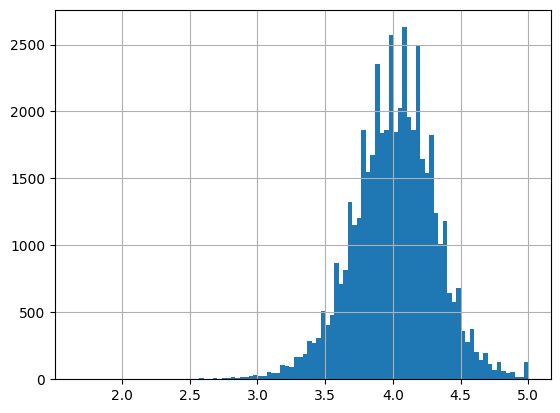

In [119]:
df['rating'].hist(bins=100)

### 2.

In [120]:
df[['pages', 'title', 'author', 'rating']].sort_values(by='pages', ascending=False).head(10)

pages                                              title   
38610   999  The Marx Sisters: A Kathy Kolla and David Broc...  \
15835   999                        The Little House Collection   
308     994                                The Wise Man's Fear   
665     993                         A Breath of Snow and Ashes   
13443   992  The Last Lion: Winston Spencer Churchill: Visi...   
16352   992                               The Endymion Omnibus   
20555   992  Three Novels of Old New York: The House of Mir...   
18606   992                     The Morganville Vampires, #1-3   
48738   992                                           Old Sins   
26042   992                                     The Art Museum   

                                                  author  rating  
38610                                     Barry Maitland    3.74  
15835  Laura Ingalls Wilder, Garth Williams (Illustra...    4.54  
308                  Patrick Rothfuss (Goodreads Author)    4.56  
665                    Diana Gabaldon (Goodreads Author)    4.44  
13443                                 William Manchester    4.35  
16352                                        Dan Simmons    4.35  
20555                                      Edith Wharton    4.29  
18606                    Rachel Caine (Goodreads Author)    4.52  
48738                                     Penny Vincenzi    4.07  
26042                                      Phaidon Press    4.38

### 3.

In [121]:
df[['title', 'author', 'rating_5']].sort_values(by='rating_5', ascending=False).head(10)

title   
32      Harry Potter and the Sorcerer's Stone  \
0                            The Hunger Games   
2                       To Kill a Mockingbird   
71       Harry Potter and the Deathly Hallows   
93   Harry Potter and the Prisoner of Azkaban   
10                     The Fault in Our Stars   
4                                    Twilight   
103       Harry Potter and the Goblet of Fire   
105    Harry Potter and the Half-Blood Prince   
3                         Pride and Prejudice   

                                        author  rating_5  
32   J.K. Rowling, Mary GrandPré (Illustrator)   4578137  
0                              Suzanne Collins   3444695  
2                                   Harper Lee   2363896  
71                                J.K. Rowling   2038930  
93   J.K. Rowling, Mary GrandPré (Illustrator)   1892635  
10               John Green (Goodreads Author)   1784471  
4                              Stephenie Meyer   1751460  
103  J.K. Rowling, Mary GrandPré (Illustrator)   1729403  
105                               J.K. Rowling   1646703  
3    Jane Austen, Anna Quindlen (Introduction)   1617567

### 4.

In [122]:
stop = stopwords.words('english')
df['title'] = df['title'].str.lower() # lowercase
df['title'] = df['title'].str.replace('[^a-zA-Z ]', '', regex=True) # remove non-alphabetic characters
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # remove stop words
df['title'] = df['title'].str.replace(' +', ' ', regex=True) # remove multiple spaces

df['title'].str.split(expand=True).stack().value_counts().head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/thanasistrisp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


life       898
love       738
story      676
vol        646
book       621
world      544
de         522
one        484
stories    444
last       420
Name: count, dtype: int64

### 5.

In [123]:
df['author'].value_counts().head(10)

author
Nora Roberts (Goodreads Author)       86
Agatha Christie                       70
Stephen King (Goodreads Author)       64
Erin Hunter                           54
Bella Forrest (Goodreads Author)      53
Meg Cabot (Goodreads Author)          51
Karen Kingsbury (Goodreads Author)    48
Terry Pratchett                       48
Bonnie Bryant                         46
Lucian Bane (Goodreads Author)        45
Name: count, dtype: int64

### 6.

In [124]:
df[['author', 'numRatings']].sort_values(by='numRatings', ascending=False).head(10)

author  numRatings
32       J.K. Rowling, Mary GrandPré (Illustrator)     7048471
0                                  Suzanne Collins     6376780
4                                  Stephenie Meyer     4964519
2                                       Harper Lee     4501075
27   F. Scott Fitzgerald, Francis Scott Fitzgerald     3775504
10                   John Green (Goodreads Author)     3550714
80                                   George Orwell     3140442
3        Jane Austen, Anna Quindlen (Introduction)     2998241
21                Veronica Roth (Goodreads Author)     2906258
147                                 J.R.R. Tolkien     2896265

### 8.

In [125]:
df['language'].value_counts().head(10)

language
English       40693
Arabic          821
Spanish         621
French          528
German          460
Indonesian      332
Portuguese      323
Italian         235
Dutch           205
Turkish         191
Name: count, dtype: int64

### 9.

In [126]:
df['publisher'].value_counts().head(10)

publisher
Vintage                                        569
HarperCollins                                  554
Penguin Books                                  424
Ballantine Books                               392
Bantam                                         365
Pocket Books                                   312
Avon                                           311
Createspace Independent Publishing Platform    286
Berkley                                        285
Del Rey                                        283
Name: count, dtype: int64

### 10.

<Axes: xlabel='pages', ylabel='rating'>

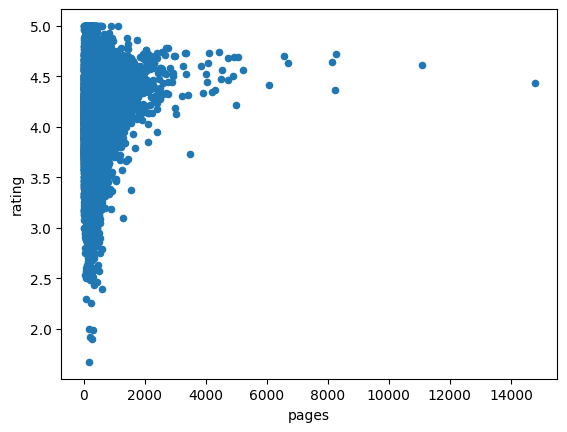

In [127]:
df1 = df.copy()
df1 = df1[df1['pages'].notna()]
df1['pages'] = df1['pages'].str.replace('[^0-9]', '', regex=True)
df1['pages'] = df1['pages'].astype(int)
df1[['pages', 'rating']].plot.scatter(x='pages', y='rating')

### 11.

<Axes: ylabel='count'>

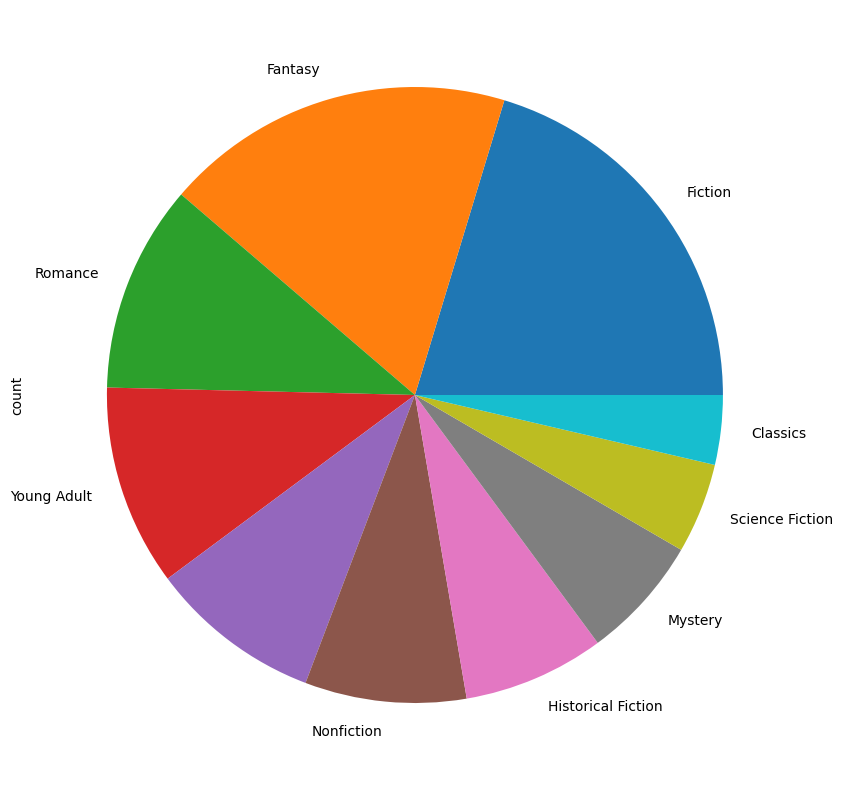

In [128]:
df['genreSingle'].value_counts().head(10).plot(kind='pie', figsize=(10, 10))

In [129]:
df['genreSingle'].str.split(',', expand=True).stack().value_counts().head(10)

Fiction               5954
Fantasy               5396
Romance               3195
Young Adult           3094
                      2654
Nonfiction            2483
Historical Fiction    2176
Mystery               1906
Science Fiction       1389
Classics              1069
Name: count, dtype: int64

In [130]:
df['awards'].str.split(',', expand=True).stack().value_counts().head(10)

[]                                                                    38080
 'LovelyBooks Leserpreis Nominee for Allgemeine Literatur (2009)']       27
 'Lincoln Award Nominee (2014)'                                          17
 'Lincoln Award Nominee (2015)'                                          16
['Goodreads Choice Award Nominee for Romance (2014)']                    15
 'Lincoln Award Nominee (2013)'                                          14
['Goodreads Choice Award Nominee for Romance (2016)']                    14
['Goodreads Choice Award Nominee for Romance (2015)']                    14
['Goodreads Choice Award Nominee for Romance (2013)']                    14
['Goodreads Choice Award Nominee for Paranormal Fantasy (2012)']         13
Name: count, dtype: int64

### 12.

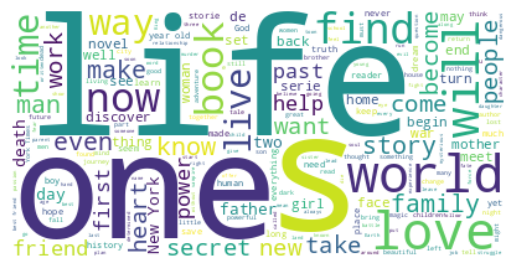

In [131]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

text = " ".join(desc for desc in df.description)

stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 13.

<Axes: xlabel='publishYear'>

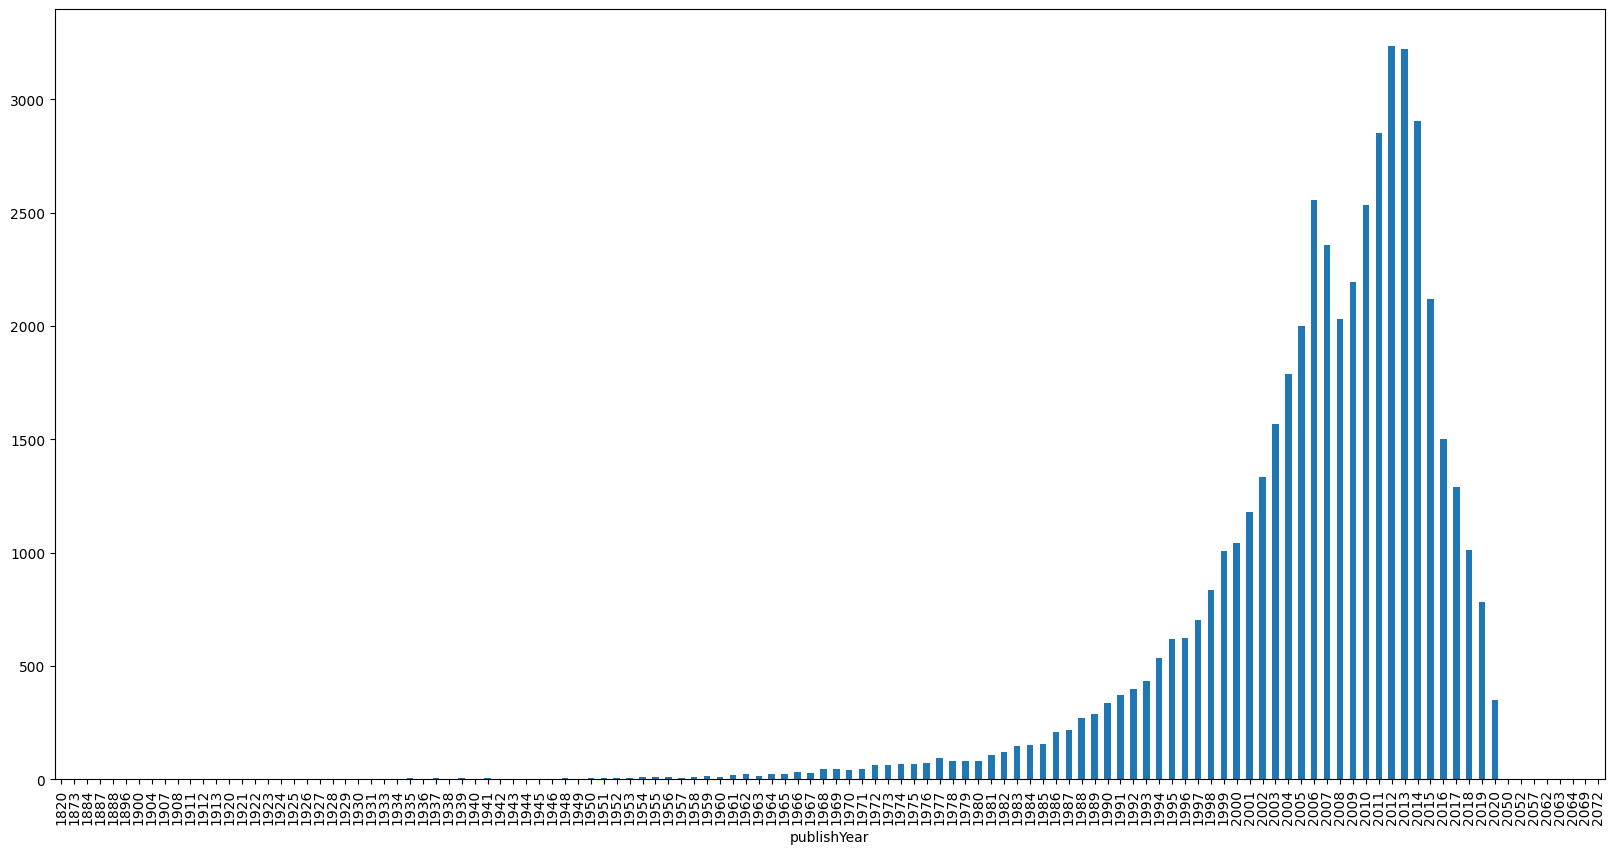

In [132]:
df['publishYear'].value_counts().sort_index().plot(kind='bar', figsize=(20, 10))

## Implementation of recomendation system

### Preprocessing

In [133]:
df1 = df_original.copy()
df1 = df1[df1['language'] == 'English']
df1 = df1[['bookId', 'description']]

In [134]:
df1.dropna(inplace=True)

In [136]:
print(df1['description'].head())

0    WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
1    There is a door at the end of a silent corrido...
2    The unforgettable novel of a childhood in a sl...
3    Alternate cover edition of ISBN 9780679783268S...
4    About three things I was absolutely positive.\...
Name: description, dtype: object


### Unigrams

In [137]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english', lowercase=True)
tfidf_matrix = tf.fit_transform(df1['description'])


In [138]:
df1.head()

bookId   
0                     2767052-the-hunger-games  \
1  2.Harry_Potter_and_the_Order_of_the_Phoenix   
2                   2657.To_Kill_a_Mockingbird   
3                     1885.Pride_and_Prejudice   
4                               41865.Twilight   

                                         description  
0  WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...  
1  There is a door at the end of a silent corrido...  
2  The unforgettable novel of a childhood in a sl...  
3  Alternate cover edition of ISBN 9780679783268S...  
4  About three things I was absolutely positive.\...

In [139]:
dict = {}
for i in range(0, len(df1)):
	cosine_similarities = cosine_similarity(tfidf_matrix[i], tfidf_matrix).flatten()
	related_docs_indices = cosine_similarities.argsort()[:-100:-1] # get the 100 most similar books
	# store in dictionary a list of tuples (bookId, similarity score)
	dict[df1['bookId'].iloc[i]] = [(df1['bookId'].iloc[related_docs_indices[x]], cosine_similarities[related_docs_indices[x]]) for x in range(0, len(related_docs_indices))]

We keep and the same book to verify that it is the first with 1.0 score similarity.

In [140]:
# save dictionary to file
import json
with open('dictionary_uni.json', 'w') as fp:
	json.dump(dict, fp)


In [141]:
# load dictionary from file
with open('dictionary_uni.json', 'r') as fp:
	dict1 = json.load(fp)

dict1['2767052-the-hunger-games']

[['2767052-the-hunger-games', 1.0000000000000002],
 ['20349441-sampler-only', 0.45891546452491827],
 ['7260188-mockingjay', 0.42381271345117066],
 ['6148028-catching-fire', 0.37017260505568433],
 ['12414235-guide-to-the-hunger-games', 0.29203328391261546],
 ['13027304-the-hunger-games-tribute-guide', 0.25241722551453866],
 ['13096765-the-hunger-but-mainly-death-games', 0.2125219429087459],
 ['7938275-the-hunger-games-trilogy-boxset', 0.17442650856979028],
 ['49176.Games_People_Play', 0.1735670970776006],
 ['12461366-j-d-robb-10-books-death-series-collection-set',
  0.14467610148076976],
 ['215540.The_Quillan_Games', 0.13196907783785797],
 ['176698.Rules_of_Play', 0.13077595151961868],
 ['16054808-escape-from-mr-lemoncello-s-library', 0.12168016047757621],
 ['68571.The_Ultimate_History_of_Video_Games', 0.1213589156475017],
 ['828140.Yu_Gi_Oh_Vol_1', 0.12098666001289199],
 ['10297152-reality-is-broken', 0.12097755287516598],
 ['348265.The_Secret_Place', 0.11859403358958406],
 ['22571758-

In [142]:
def recommend(item_id, num):
	index = df1[df1['bookId'] == item_id].index[0]
	cs = cosine_similarity(tfidf_matrix[index], tfidf_matrix).flatten()
	related_docs_indices = cs.argsort()[:-num:-1] # get the N most similar books
	related_docs_indices = related_docs_indices.tolist()
	# related_docs_indices.remove(index) # remove the book itself from the list
	print("Recommending " + str(num) + " books similar to " + df1['bookId'].iloc[index])
	print("------------------------------------------------------")
	for i in range(0, len(related_docs_indices)):
		print("Recommended: ", df1['bookId'].iloc[related_docs_indices[i]])
		print("Description: ", df1['description'].iloc[related_docs_indices[i]])
		print("Similarity score: ", cs[related_docs_indices[i]])
		print("------------------------------------------------------")
		

In [143]:
recommend("2767052-the-hunger-games", 5)

Recommending 5 books similar to 2767052-the-hunger-games
------------------------------------------------------
Recommended:  2767052-the-hunger-games
Description:  WINNING MEANS FAME AND FORTUNE.LOSING MEANS CERTAIN DEATH.THE HUNGER GAMES HAVE BEGUN. . . .In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV.Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against

### Bigrams

In [144]:
tf2 = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=0, stop_words='english', lowercase=True)
tfidf_matrix = tf2.fit_transform(df1['description'])

In [145]:
dict = {}
for i in range(0, len(df1)):
	cosine_similarities = cosine_similarity(tfidf_matrix[i], tfidf_matrix).flatten()
	related_docs_indices = cosine_similarities.argsort()[:-100:-1] # get the 100 most similar books
	# store in dictionary a list of tuples (bookId, similarity score)
	dict[df1['bookId'].iloc[i]] = [(df1['bookId'].iloc[related_docs_indices[x]], cosine_similarities[related_docs_indices[x]]) for x in range(0, len(related_docs_indices))]

In [146]:
# save dictionary to file
import json
with open('dictionary_bi.json', 'w') as fp:
	json.dump(dict, fp)

In [147]:
# load dictionary from file
with open('dictionary_bi.json', 'r') as fp:
	dict2 = json.load(fp)

dict2['2767052-the-hunger-games']

[['2767052-the-hunger-games', 0.9999999999999996],
 ['20349441-sampler-only', 0.11295709758338973],
 ['13027304-the-hunger-games-tribute-guide', 0.08987342611073566],
 ['12414235-guide-to-the-hunger-games', 0.07260355097857038],
 ['7260188-mockingjay', 0.057568461398916894],
 ['7938275-the-hunger-games-trilogy-boxset', 0.057037599642651295],
 ['6148028-catching-fire', 0.04149132501157078],
 ['13096765-the-hunger-but-mainly-death-games', 0.03821457514885354],
 ['51901147-the-ballad-of-songbirds-and-snakes', 0.037425563574225815],
 ['11742691-the-hunger-games', 0.03012293089714473],
 ['24885710-the-dust-lands-trilogy', 0.028170721188300506],
 ['26309016-throne-of-glass-collection', 0.02663036628707167],
 ['682742.The_Golden_Key', 0.023885609801866443],
 ['1832749.I_Heart_You_You_Haunt_Me', 0.023828795033982983],
 ['825473.The_Devil_s_Alternative', 0.02376887668361493],
 ['2911494-captain-america', 0.023421401906764495],
 ['17623910-catching-fire', 0.022410521640537275],
 ['655570.Island_

In [148]:
recommend("2767052-the-hunger-games", 5)

Recommending 5 books similar to 2767052-the-hunger-games
------------------------------------------------------
Recommended:  2767052-the-hunger-games
Description:  WINNING MEANS FAME AND FORTUNE.LOSING MEANS CERTAIN DEATH.THE HUNGER GAMES HAVE BEGUN. . . .In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV.Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against

### Compare Unigrams and Bigrams average similarity score for each book totally

In [149]:
def avg_similarity(dict):
	avg = []
	for key in dict:
		avg.append(np.mean([x[1] for x in dict[key]]))
	return np.mean(avg)

print("Average similarity score for unigrams: ", avg_similarity(dict1))
print("Average similarity score for bigrams: ", avg_similarity(dict2))


Average similarity score for unigrams:  0.11221116862361008
Average similarity score for bigrams:  0.024823510353536783


## Implementation of classification system

### Preprocessing

In [8]:
df2 = df.copy()
df2 = df2[df2['language'] == 'English']

df2 = df2[['bookId', 'description', 'genreSingle']]
df2.dropna(inplace=True)

print(len(df2['genreSingle'].unique()))

print(df2.shape)

# keep only books with 10 most frequent genres
df2 = df2[df2['genreSingle'].isin(df2['genreSingle'].value_counts().head(10).index)]
print(df2.shape)

print(len(df2['genreSingle'].unique()))
print(df2['genreSingle'].value_counts())

359
(41365, 3)
(25442, 3)
10
genreSingle
Fiction               4990
Fantasy               4855
Young Adult           2894
Romance               2825
Nonfiction            2117
Historical Fiction    1951
                      1825
Mystery               1818
Science Fiction       1284
Classics               883
Name: count, dtype: int64


In [36]:
df2.head()

bookId   
0                     2767052-the-hunger-games  \
1  2.Harry_Potter_and_the_Order_of_the_Phoenix   
2                   2657.To_Kill_a_Mockingbird   
3                     1885.Pride_and_Prejudice   
4                               41865.Twilight   

                                         description  genreSingle  
0  WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...  Young Adult  
1  There is a door at the end of a silent corrido...      Fantasy  
2  The unforgettable novel of a childhood in a sl...     Classics  
3  Alternate cover edition of ISBN 9780679783268S...     Classics  
4  About three things I was absolutely positive.\...  Young Adult

Clean description column

In [9]:
# remove symbols
df2['description'] = df2['description'].str.replace('[^a-zA-Z ]', ' ', regex=True)
# keep only words with length > 1
df2['description'] = df2['description'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
# convert to lowercase
df2['description'] = df2['description'].apply(lambda x: x.lower())
# remove stopwords
stop = stopwords.words('english')
df2['description'] = df2['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# lemmatisation
lemmatizer = WordNetLemmatizer()
df2['description'] = df2['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
# stem words
stemmer = PorterStemmer()
df2['description'] = df2['description'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
# convert numbers to words
p = inflect.engine()
df2['description'] = df2['description'].apply(lambda x: ' '.join([p.number_to_words(word) if word.isdigit() else word for word in x.split()]))

In [59]:
df2.head()

bookId   
0                     2767052-the-hunger-games  \
1  2.Harry_Potter_and_the_Order_of_the_Phoenix   
2                   2657.To_Kill_a_Mockingbird   
3                     1885.Pride_and_Prejudice   
4                               41865.Twilight   

                                         description  genreSingle  
0  win mean fame fortun lose mean certain death h...  Young Adult  
1  door end silent corridor haunt harri pottter d...      Fantasy  
2  unforgett novel childhood sleepi southern town...     Classics  
3  altern cover edit isbn sinc immedi success pri...     Classics  
4  three thing absolut posit first edward vampir ...  Young Adult

We will use pre-trained word embeddings from GloVe.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove6B.zip

In [10]:
# load the corpus in GloVe format
embeddings = dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings[word] = coefs
f.close()
print('Total %s word vectors.' % len(embeddings))

Total 400001 word vectors.


In [11]:
def get_average_vector(description):
	words = description.split()
	vector = []
	for word in words:
		if word in embeddings: # if word is in the corpus, append its vector else do not add them
			vector.append(embeddings[word])
	if len(vector) == 0: # if no words from the description are in the corpus, return a random vector
		return np.random.rand(300)
	return np.mean(vector, axis=0)
	
df2['description'] = df2['description'].apply(lambda x: get_average_vector(x))


In [104]:
df2

bookId   
0                         2767052-the-hunger-games  \
1      2.Harry_Potter_and_the_Order_of_the_Phoenix   
2                       2657.To_Kill_a_Mockingbird   
3                         1885.Pride_and_Prejudice   
4                                   41865.Twilight   
...                                            ...   
52471                           12464361-elemental   
52472                        12395883-unbelievable   
52474                             11836711-anasazi   
52475                              10815662-marked   
52476                         11330278-wayward-son   

                                             description  genreSingle  
0      [-0.049650975, 0.14017278, -0.05292188, -0.043...  Young Adult  
1      [-0.05211142, 0.057346884, -0.0173778, -0.1047...      Fantasy  
2      [-0.072321475, 0.06848502, -0.016366718, -0.00...     Classics  
3      [0.006563154, -0.04762013, 0.09470726, -0.0961...     Classics  
4      [-0.051030107, 0.08003205, -0.09550331, -0.040...  Young Adult  
...                                                  ...          ...  
52471  [-0.022208966, -0.003352337, -0.15694036, -0.1...      Fantasy  
52472  [-0.056620583, 0.018445166, 0.033989962, 0.070...      Romance  
52474  [-0.1325988, -0.013051008, -0.14605607, 0.0156...      Mystery  
52475  [-0.043218948, 0.0063914075, -0.021412425, -0....      Fantasy  
52476  [-0.09929829, 0.005382947, -0.16483839, -0.113...      Fiction  

[25034 rows x 3 columns]

In [12]:
# save dataframe to file
df2.to_pickle('df2.pkl')

In [2]:
# load dataframe from file
df2 = pd.read_pickle('df2.pkl')

### Classification

In [3]:
# split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2['description'], df2['genreSingle'], test_size=0.2, random_state=42)

In [4]:
# transform the train and test sets into numpy arrays
X_train = np.array([x for x in X_train])
X_test = np.array([x for x in X_test])

# transform the genre labels into numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#### Naive Bayes Gaussian

In [5]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [6]:
# naive bayes classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

print("Accuracy score for Naive Bayes: ", accuracy_score(y_test, y_pred))
scores = cross_val_score(gnb, X_train, y_train, cv=10)
print(classification_report(y_test, y_pred))

Accuracy score for Naive Bayes:  0.4034191393201022
              precision    recall  f1-score   support

           0       0.16      0.16      0.16       362
           1       0.18      0.34      0.24       187
           2       0.68      0.52      0.59       964
           3       0.52      0.23      0.32       995
           4       0.38      0.44      0.41       371
           5       0.44      0.45      0.44       340
           6       0.56      0.34      0.42       448
           7       0.29      0.76      0.42       568
           8       0.50      0.47      0.48       244
           9       0.44      0.30      0.36       610

    accuracy                           0.40      5089
   macro avg       0.41      0.40      0.38      5089
weighted avg       0.46      0.40      0.40      5089



#### Naive Bayes Bernoulli

In [7]:
# naive bayes bernoulli classifier
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train, y_train)

y_pred = bnb.predict(X_test)

print("Accuracy score for Naive Bayes Bernoulli: ", scores.mean())
scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(classification_report(y_test, y_pred))

Accuracy score for Naive Bayes Bernoulli:  0.4075070837939207
              precision    recall  f1-score   support

           0       0.19      0.09      0.12       362
           1       0.19      0.49      0.28       187
           2       0.67      0.55      0.60       964
           3       0.49      0.27      0.35       995
           4       0.34      0.41      0.37       371
           5       0.45      0.48      0.46       340
           6       0.48      0.38      0.42       448
           7       0.36      0.67      0.47       568
           8       0.41      0.55      0.47       244
           9       0.40      0.38      0.39       610

    accuracy                           0.42      5089
   macro avg       0.40      0.42      0.39      5089
weighted avg       0.45      0.42      0.42      5089



#### Support Vector Machine

We use optuna to find the best hyperparameters, which is random search.

In [9]:
# use optuna to find the best parameters for the svm classifier
import optuna
from optuna.visualization import plot_parallel_coordinate
from sklearn.svm import SVC

def objective(trial):
    # kernel parameter
    kernel = trial.suggest_categorical('kernel', ['linear','rbf'])
    # c parameter
    c = trial.suggest_float('c', 1e-2, 1e2, log=True)

    # create the classifier
    svc = SVC(kernel=kernel, C=c, gamma='auto')

    # train the classifier
    svc.fit(X_train, y_train)

    # predict the test set
    y_pred = svc.predict(X_test)

    # return the accuracy score
    return accuracy_score(y_test, y_pred)



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# save best parameters
best_params = study.best_params

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-09 11:30:02,862] A new study created in memory with name: no-name-8152bbfa-d1b6-4b04-84e0-ea78c9028f9e
[I 2023-05-09 11:31:20,464] Trial 0 finished with value: 0.5562978974258204 and parameters: {'kernel': 'linear', 'c': 0.20863141808184316}. Best is trial 0 with value: 0.5562978974258204.
[I 2023-05-09 11:33:56,702] Trial 1 finished with value: 0.32776576930634704 and parameters: {'kernel': 'rbf', 'c': 0.35179401763671336}. Best is trial 0 with value: 0.5562978974258204.
[I 2023-05-09 11:36:18,378] Trial 2 finished with value: 0.5659265081548438 and parameters: {'kernel': 'linear', 'c': 24.609130921810067}. Best is trial 2 with value: 0.5659265081548438.
[I 2023-05-09 11:38:56,283] Trial 3 finished with value: 0.19551974847710749 and parameters: {'kernel': 'rbf', 'c': 0.023718797259495297}. Best is trial 2 with value: 0.5659265081548438.
[I 2023-05-09 11:41:37,095] Trial 4 finished with value: 0.19551974847710749 and parameters: {'kernel': 'rbf', 'c': 0.010172029004803556}.

Number of finished trials: 50
Best trial: {'kernel': 'linear', 'c': 24.609130921810067}


We added a range of (0.01,100) for C and auto for gamma (auto adjusts itself) and choose discretically two kernel values to find the best hyperparameters. Maybe with bigger C we could have better results, but this requires more time to run.
The best we could achieve was about 60% accuracy.

In [5]:
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study).show()

In [20]:
# svm classifier from previous best parameters
kernel, c = best_params['kernel'], best_params['c']
clf = SVC(kernel=kernel, C=c, gamma='auto')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy score for SVM: ", accuracy_score(y_test, y_pred))
scores = cross_val_score(clf, X_train, y_train, cv=10)
print(classification_report(y_test, y_pred))

Accuracy score for SVM:  0.5659265081548438
              precision    recall  f1-score   support

           0       0.27      0.17      0.21       362
           1       0.47      0.34      0.39       187
           2       0.70      0.74      0.72       964
           3       0.50      0.60      0.54       995
           4       0.54      0.47      0.50       371
           5       0.60      0.61      0.61       340
           6       0.61      0.57      0.59       448
           7       0.58      0.61      0.60       568
           8       0.65      0.61      0.63       244
           9       0.53      0.51      0.52       610

    accuracy                           0.57      5089
   macro avg       0.54      0.52      0.53      5089
weighted avg       0.56      0.57      0.56      5089



#### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print("Accuracy score for Random Forest: ", accuracy_score(y_test, y_pred))
scores = cross_val_score(rfc, X_train, y_train, cv=10)
print(classification_report(y_test, y_pred))

Accuracy score for Random Forest:  0.4594222833562586
              precision    recall  f1-score   support

           0       0.37      0.05      0.09       362
           1       0.50      0.02      0.03       187
           2       0.51      0.77      0.62       964
           3       0.37      0.75      0.50       995
           4       0.62      0.13      0.22       371
           5       0.69      0.36      0.47       340
           6       0.63      0.26      0.37       448
           7       0.45      0.52      0.48       568
           8       0.80      0.19      0.31       244
           9       0.46      0.32      0.38       610

    accuracy                           0.46      5089
   macro avg       0.54      0.34      0.35      5089
weighted avg       0.51      0.46      0.42      5089



#### Results

| Method | Accuracy | Precision | Recall | F1-score |
| --- | --- | --- | --- | --- |
| Naive Bayes Gaussian | 0.40 | 0.46 | 0.40 | 0.40 |
| Naive Bayes Bernoulli | 0.40 | 0.45 | 0.42 | 0.42 |
| Support Vector Machine | 0.57 | 0.56 | 0.57 | 0.56 |
| Random Forest | 0.46 | 0.54 | 0.46 | 0.42 |

## Bonus - Judge a book by its cover

### First step

In [2]:
import os
import csv
import time
import urllib.request

In [3]:
def get_books_cover(books, bookIds, img_dir):
        """
        Retrieves books covers to a img/ directory
        Will work on existing books class attribute, so a GoodReads list should be scraped or a books list loaded
        (csv_to_books) before use.
        :return: None
        """
        check_folder = os.path.isdir(img_dir)

        # If folder doesn't exist, then create it.
        if not check_folder:
            os.makedirs(img_dir)
            print("Creating folder: ", img_dir)

        else:
            print(img_dir, "folder already exists, saving images to folder.")

        # Download covers
        for (book, bookId) in zip(books, bookIds):
                print("Downloading: ", book)
                print("Saved as: ", bookId + ".jpg")
                urllib.request.urlretrieve(
                     book, img_dir + "/" + bookId + ".jpg"
                )

In [4]:
import pandas as pd
file = "books_1.Best_Books_Ever.csv"

In [5]:
finalbooks = pd.read_csv(file)
# drop nans
finalbooks = finalbooks.dropna()
# keep only english books
finalbooks = finalbooks[finalbooks['language'] == 'English']

In [6]:
# drop image with bookid "34219873-the-trials-of-morrigan-crow"
finalbooks = finalbooks[finalbooks['bookId'] != '34219873-the-trials-of-morrigan-crow']

In [7]:
# keep 500 books
finalbooks = finalbooks[:500]
finalbooks

bookId  \
1      2.Harry_Potter_and_the_Order_of_the_Phoenix   
8                30.J_R_R_Tolkien_4_Book_Boxed_Set   
29                             375802.Ender_s_Game   
37                                   17245.Dracula   
42                       28187.The_Lightning_Thief   
...                                            ...   
26401                         20734410-brainwashed   
26645                      21066604-half-the-world   
26769                          20995607-wraithsong   
26945                         24830026-the-valiant   
27158                  2326576.The_Age_of_Darkness   

                                                   title  \
1              Harry Potter and the Order of the Phoenix   
8      J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...   
29                                          Ender's Game   
37                                               Dracula   
42                                   The Lightning Thief   
...                                                  ...   
26401                                        Brainwashed   
26645                                     Half the World   
26769                                         Wraithsong   
26945                                        The Valiant   
27158                                The Age of Darkness   

                                   series  \
1                         Harry Potter #5   
8              The Lord of the Rings #0-3   
29                        Ender's Saga #1   
37                             Dracula #1   
42     Percy Jackson and the Olympians #1   
...                                   ...   
26401                  Crime Travelers #1   
26645                    Shattered Sea #2   
26769              Desirable Creatures #1   
26945                    The Valiant #1-4   
27158                  L'âge d'ombre #1-2   

                                                  author  rating  \
1              J.K. Rowling, Mary GrandPré (Illustrator)    4.50   
8                                         J.R.R. Tolkien    4.60   
29     Orson Scott Card, Stefan Rudnicki (Narrator), ...    4.30   
37     Bram Stoker, Nina Auerbach (Editor), David J. ...    4.00   
42                       Rick Riordan (Goodreads Author)    4.26   
...                                                  ...     ...   
26401                    Paul Aertker (Goodreads Author)    4.19   
26645                                    Joe Abercrombie    4.20   
26769                    E.J. Squires (Goodreads Author)    3.77   
26945  Jeff Lemire (Writer, Artist), Matt Kindt (Good...    3.80   
27158                                               Caza    4.15   

                                             description language  \
1      There is a door at the end of a silent corrido...  English   
8      This four-volume, boxed set contains J.R.R. To...  English   
29     Andrew "Ender" Wiggin thinks he is playing com...  English   
37     You can find an alternative cover edition for ...  English   
42     Alternate cover for this ISBN can be found her...  English   
...                                                  ...      ...   
26401  While sleeping on the roof of his father’s hot...  English   
26645  Thorn Bathu was born to fight. But when she ki...  English   
26769  Winner of the SILVER MEDAL in the 2014 Readers...  English   
26945  From New York Times best-selling writers Jeff ...  English   
27158  This beautiful graphic novel tells of the time...  English   

                isbn                                             genres  \
1      9780439358071  ['Fantasy', 'Young Adult', 'Fiction', 'Magic',...   
8      9780345538376  ['Fantasy', 'Fiction', 'Classics', 'Adventure'...   
29     9780812550702  ['Science Fiction', 'Fiction', 'Young Adult', ...   
37     9780393970128  ['Classics', 'Horror', 'Fiction', 'Fantasy', '...   
42     9780786838653  ['Fantasy', 'Young Adult', 'Mythology', 'Ficti...   
...              ...                 

In [8]:
# keep 475 for training and 25 for testing
train_set = finalbooks[:475]
test_set = finalbooks[475:]

In [13]:
images_train = train_set['coverImg']
Ids_train = train_set['bookId']
get_books_cover(images_train, Ids_train, 'img_train')

img_train folder already exists, saving images to folder.
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1546910265l/2.jpg
Saved as:  2.Harry_Potter_and_the_Order_of_the_Phoenix.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1346072396l/30.jpg
Saved as:  30.J_R_R_Tolkien_4_Book_Boxed_Set.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1408303130l/375802.jpg
Saved as:  375802.Ender_s_Game.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1387151694l/17245.jpg
Saved as:  17245.Dracula.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1400602609l/28187.jpg
Saved as:  28187.The_Lightning_Thief.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1507963312l/33574273._SX318_.jpg
Saved as:  33574273-a-wrinkle-in-time.jpg
Downloading:  https://i.gr-assets.com/images/S

In [15]:
train_set.shape

(475, 25)

In [14]:
images_test = test_set['coverImg']
Ids_test = test_set['bookId']
get_books_cover(images_test, Ids_test, 'img_test')

img_test folder already exists, saving images to folder.
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1344217267l/15789177.jpg
Saved as:  15789177-butterfly-weeds.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1405071991l/21851827.jpg
Saved as:  21851827-dog-days-of-summer.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1384456102l/18107951.jpg
Saved as:  18107951-midnight-crossroad.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1327098344l/451521.jpg
Saved as:  451521.The_Second_Chronicles_of_Amber.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1417018552l/23615955._SY475_.jpg
Saved as:  23615955-lawyers-gone-bad.jpg
Downloading:  https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1391041443l/132380.jpg
Saved as:  132380.Politically_Correct_Bedtime_Stories.jpg
Downloa

### Second step

In [62]:
import cv2

def get_histogram(image, channel, path='img_train/'):
    """
    Calculates the histogram of an image
    :param image: image to calculate the histogram
    :return: histogram of the image
    """
    image = cv2.imread(path + image + '.jpg')
    hist = cv2.calcHist([image], [channel], None, [32], [0, 256])
    # hist = cv2.normalize(hist, hist).flatten()

    return hist

In [63]:
# for each channel, create a histogram into a vector and then unify 3 vectors into one
# it will be a dataframe with histograms for each image and an id to be able to distinguish them
def create_histograms(images):
    """
    Creates histograms for each image and unifies them into one vector
    :param images: images to create histograms
    :param Ids: ids of the images
    :return: dataframe with histograms for each image and an id to be able to distinguish them
    """
    df_train = pd.DataFrame()
    for image in images:
        hist_b = get_histogram(image, 0)
        hist_g = get_histogram(image, 1)
        hist_r = get_histogram(image, 2)
        # unify 3 vectors into one and add them to a dataframe with its id
        hist = np.concatenate((hist_b, hist_g, hist_r), axis=None)
        df_train = df_train.append({'id': image, 'hist': hist}, ignore_index=True)

    return df_train


# create histograms for training and testing images
df_train = create_histograms(Ids_train)

/tmp/ipykernel_15982/2094936617.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append({'id': image, 'hist': hist}, ignore_index=True)
/tmp/ipykernel_15982/2094936617.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append({'id': image, 'hist': hist}, ignore_index=True)
/tmp/ipykernel_15982/2094936617.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append({'id': image, 'hist': hist}, ignore_index=True)
/tmp/ipykernel_15982/2094936617.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append({'id': image, 'hist': hist}, ignore_index=True)
/tmp

In [17]:
df_train.head()

id  \
0  2.Harry_Potter_and_the_Order_of_the_Phoenix   
1            30.J_R_R_Tolkien_4_Book_Boxed_Set   
2                          375802.Ender_s_Game   
3                                17245.Dracula   
4                    28187.The_Lightning_Thief   

                                                hist  
0  [0.0, 0.0, 0.0, 7.0, 36.0, 169.0, 628.0, 1938....  
1  [24614.0, 10029.0, 8722.0, 11095.0, 12368.0, 8...  
2  [31483.0, 22077.0, 9322.0, 5144.0, 4223.0, 331...  
3  [50582.0, 8193.0, 1381.0, 1805.0, 7792.0, 1536...  
4  [396.0, 295.0, 450.0, 841.0, 2092.0, 5203.0, 9...

In [64]:
print(df_train.shape)

(475, 2)


### Third step

In [75]:
# choose first image from test
# get a random image from test
random = np.random.randint(0, len(Ids_test))
image = Ids_test.iloc[random]
print(image)
# get its histogram
for i in range(3):
    hist_b = get_histogram(image, 0, 'img_test/')
    hist_g = get_histogram(image, 1, 'img_test/')
    hist_r = get_histogram(image, 2, 'img_test/')
    hist = np.concatenate((hist_b, hist_g, hist_r), axis=None)

hist

568592.Fushigi_Y_gi


array([ 1935.,  6596., 33386., 36618.,  8499.,  9973.,  4456.,  3742.,
        3029.,  2397.,  1908.,  1595.,  1472.,  1580.,  1407.,  1350.,
        1148.,  1008.,   895.,   861.,   735.,   792.,   817.,  1012.,
         948.,   850.,   915.,   949.,  1133.,  1314.,  6354.,  8196.,
         558.,  3722.,  1586.,  4098., 45648., 27127.,  9361.,  6672.,
        2804.,  2151.,  1709.,  1620.,  1601.,  1462.,  1805.,  2345.,
        1856.,  1568.,  1638.,  1782.,  1504.,  1171.,  1021.,   972.,
         950.,  1270.,  5505.,  5745.,  2311.,  2261.,  1764.,  2283.,
        1143., 16446., 50546.,  6194.,  2672.,  2295.,  1437.,  1203.,
        1069.,  1061.,  1873.,  4836.,  6536.,  3509.,  1892.,  1519.,
        1439.,  1670.,  5996.,  5948.,  2735.,  2586.,  2582.,  2990.,
        2431.,  1818.,  1568.,  1405.,  1526.,  1648.,  3517.,  3780.],
      dtype=float32)

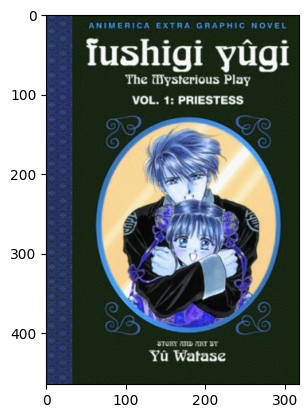

In [76]:
# print image
img = cv2.imread('img_test/' + image + '.jpg')
plt.imshow(img)

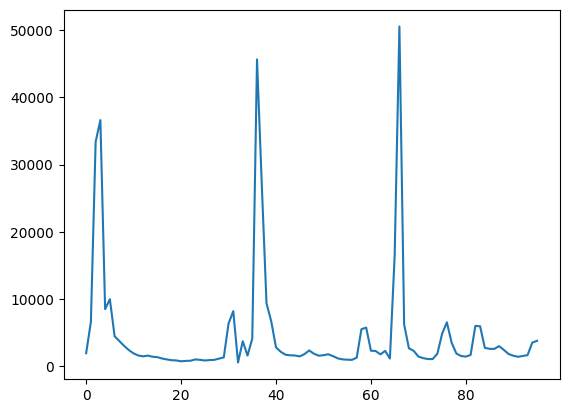

In [77]:
# print histogram
plt.plot(hist)

### Fourth step

In [78]:
# show the 4 most similar images between img and df_train using euclidean distance
def get_similar_images_euclidean(image, df_train, n=4):
    """
    Calculates the euclidean distance between an image and all the images in the training set
    :param image: image to compare
    :param df_train: dataframe with training images and their histograms
    :param n: number of images to return
    :return: dataframe with the n most similar images
    """
    # get histogram of the image
    for i in range(3):
        hist_b = get_histogram(image, 0, 'img_test/')
        hist_g = get_histogram(image, 1, 'img_test/')
        hist_r = get_histogram(image, 2, 'img_test/')
        hist = np.concatenate((hist_b, hist_g, hist_r), axis=None)

    # calculate euclidean distance between the image and all the images in the training set
    df_train['distance'] = df_train['hist'].apply(lambda x: np.linalg.norm(x - hist))

    # sort by distance
    df_train = df_train.sort_values(by=['distance'])

    # return the n most similar images
    return df_train[:n]

# get 4 most similar images
similar_images = get_similar_images_euclidean(image, df_train)
similar_images

id  \
417         6657648-lord-sunday   
78   77565.The_Fall_of_Hyperion   
57            130580.Old_Yeller   
48     30264.Dead_Witch_Walking   

                                                  hist      distance  
417  [22556.0, 23191.0, 38047.0, 25490.0, 12712.0, ...  61858.683594  
78   [1620.0, 11372.0, 21004.0, 14545.0, 11717.0, 9...  66371.851562  
57   [6574.0, 12529.0, 22860.0, 14019.0, 9313.0, 77...  66859.023438  
48   [9821.0, 7871.0, 32240.0, 24602.0, 12304.0, 85...  67663.890625

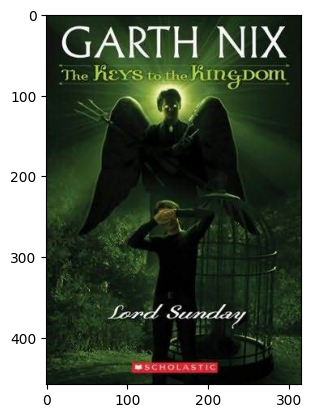

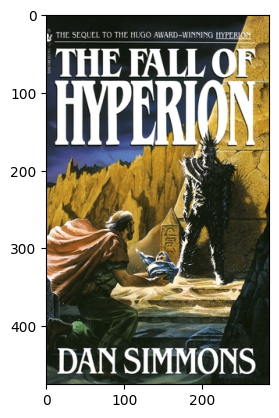

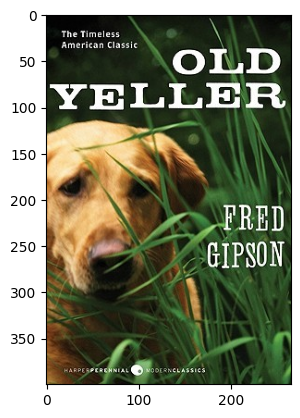

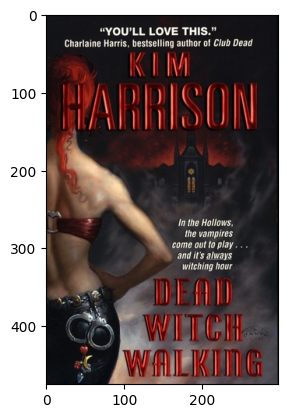

In [79]:
def show_images(images):
    """
    Shows images using matplotlib (use flip as matplotlib uses BRG and we need to convert it to RGB)
    :param images: images to show
    :return: None
    """
    for image in images:
        img = cv2.imread('img_train/' + image + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # flip from BGR to RGB
        plt.imshow(img)
        plt.show()

show_images(similar_images['id'])